# Error Rates

This evaluates the effect of various variables on *Error Rate*.

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2

%load_ext rpy2.ipython
%matplotlib inline

In [2]:
reg_palette = sns.color_palette("colorblind", 5)
sns.set_palette(reg_palette)
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv("../data/error.csv", index_col=0)
df

,User ID,Technique,Skill,Training,Background,Error rate
0,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Untrained,No-Music,7.692308
1,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Untrained,Music,0.000000
2,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Trained,No-Music,0.000000
3,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Trained,Music,0.000000
4,4g4XbueBXPakEKcHYSqqot76sGg1,Interval,Expert,Untrained,No-Music,14.285714
...,...,...,...,...,...,...
247,RIneOAfWA6POfHcHOoYEDG1BF6T2,Interval,Expert,Trained,Music,7.142857
248,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,Untrained,No-Music,7.692308
249,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,Untrained,Music,28.571429
250,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,Trained,No-Music,0.000000


In [32]:
%%R -i df

library(ARTool) # art, artlm

# Sanitize dataframe column names
library(janitor)
df <- clean_names(df)

df$technique <- factor(df$technique)
df$skill <- factor(df$skill)
df$background <- factor(df$background)
df$training <- factor(df$training)
df$user_id <- factor(df$user_id)

# Error Rate Stats

## Test for normality

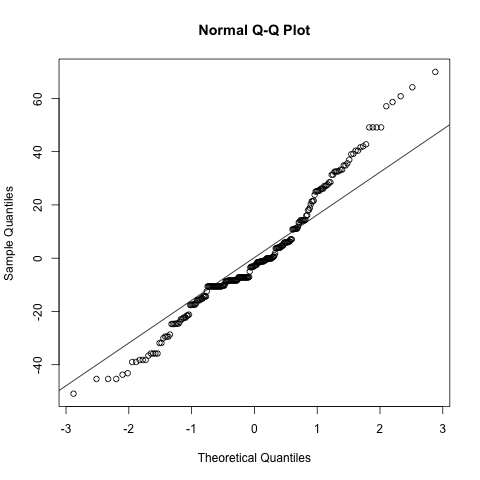

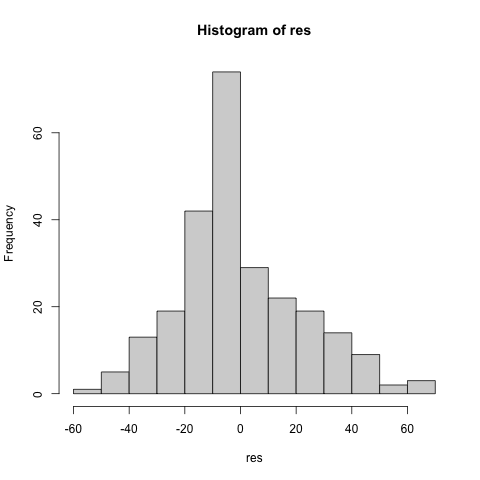

In [5]:
%%R
m = aov(error_rate ~ technique*skill, data=df)
res = residuals(m)
qqnorm(res)
qqline(res)
hist(res)

## Pitch: Background X Training X Skill ANOVA

In [6]:
%%R
pitch_df <- subset(df, technique == "Pitch")
pitch_df_art <- art(error_rate ~ skill * training * background + Error(user_id / (training * background)) + skill, data = pitch_df)
summary(pitch_df_art)

Aligned Rank Transform of Factorial Model

Call:
art(formula = error_rate ~ skill * training * background + Error(user_id/(training * 
    background)) + skill, data = pitch_df)

Column sums of aligned responses (should all be ~0):
                    skill                  training                background 
                        0                         0                         0 
           skill:training          skill:background       training:background 
                        0                         0                         0 
skill:training:background 
                        0 

F values of ANOVAs on aligned responses not of interest (should all be ~0):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


In [7]:
%%R
m = anova(pitch_df_art)
m$eta.sq.part = with(m, `Sum Sq`/(`Sum Sq` + `Sum Sq.res`))
print(m)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Repeated Measures Analysis of Variance Table (Type I) 
Model: Repeated Measures (aov)
Response: art(error_rate)

                              Error Df Df.res F value     Pr(>F) eta.sq.part
1 skill                       usr_d  2     18 43.7307 1.2292e-07    0.829321
2 training                  usr_d:t  1     18 43.5226 3.3961e-06    0.707425
3 background                usr_d:b  1     18  4.1121   0.057643    0.185968
4 skill:training            usr_d:t  2     18  3.7355   0.043959    0.293313
5 skill:background          usr_d:b  2     18  1.3860   0.275519    0.133448
6 training:background         us_::  1     18  1.3727   0.256622    0.070858
7 skill:training:background   us_::  2     18  1.4223   0.267006    0.136465
                               
1 skill                     ***
2 training                  ***
3 background                  .
4 skill:training              *
5 skill:background             
6 training:b

### Pitch post-hoc: Skill

In [8]:
%%R
suppressMessages(art.con(pitch_df_art, "skill", interaction = FALSE))

 contrast              estimate   SE df t.ratio p.value
 Expert - Intermediate    -26.4 4.94 18  -5.344  0.0001
 Expert - Novice          -43.8 4.73 18  -9.254  <.0001
 Intermediate - Novice    -17.4 5.08 18  -3.421  0.0081

Results are averaged over the levels of: training, background 
P value adjustment: tukey method for comparing a family of 3 estimates 


In [9]:
df[(df["Technique"] == "Pitch")].groupby(["Skill"]).mean()

,Error rate
Skill,
Expert,10.602679
Intermediate,35.805861
Novice,59.635008


### Pitch post-hoc: Training

In [10]:
%%R
suppressMessages(art.con(pitch_df_art, "training", interaction = FALSE))

 contrast            estimate   SE df t.ratio p.value
 Trained - Untrained    -31.5 4.83 18  -6.514  <.0001

Results are averaged over the levels of: skill, background 


In [11]:
df[(df["Technique"] == "Pitch")].groupby(["Training"]).mean()

,Error rate
Training,
Trained,19.557823
Untrained,48.737572


### Pitch post-hoc: Skill X Training

In [12]:
%%R
suppressMessages(art.con(pitch_df_art, "skill:training", interaction = TRUE))

 skill_pairwise        training_pairwise   estimate   SE df t.ratio p.value
 Expert - Intermediate Trained - Untrained     41.2 15.2 18   2.718  0.0141
 Expert - Novice       Trained - Untrained     21.4 14.5 18   1.471  0.1585
 Intermediate - Novice Trained - Untrained    -19.9 15.6 18  -1.270  0.2202

Results are averaged over the levels of: background 


In [13]:
df[(df["Technique"] == "Pitch")].groupby(["Skill", "Training"]).mean()

Error rate
Skill        Training             
Expert       Trained      1.339286
             Untrained   19.866071
Intermediate Trained     13.095238
             Untrained   58.516484
Novice       Trained     45.918367
             Untrained   73.351648

## Interval: Background X Training X Skill ANOVA

In [14]:
%%R
interval_df <- subset(df, technique == "Interval")
interval_df_art <- art(error_rate ~ skill * training * background + Error(user_id / (training * background)) + skill, data = interval_df)
summary(interval_df_art)

Aligned Rank Transform of Factorial Model

Call:
art(formula = error_rate ~ skill * training * background + Error(user_id/(training * 
    background)) + skill, data = interval_df)

Column sums of aligned responses (should all be ~0):
                    skill                  training                background 
                        0                         0                         0 
           skill:training          skill:background       training:background 
                        0                         0                         0 
skill:training:background 
                        0 

F values of ANOVAs on aligned responses not of interest (should all be ~0):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


In [15]:
%%R
m = anova(interval_df_art)
m$eta.sq.part = with(m, `Sum Sq`/(`Sum Sq` + `Sum Sq.res`))
print(m)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Repeated Measures Analysis of Variance Table (Type I) 
Model: Repeated Measures (aov)
Response: art(error_rate)

                              Error Df Df.res  F value     Pr(>F) eta.sq.part
1 skill                       usr_d  2     18 22.33440 1.3304e-05    0.712776
2 training                  usr_d:t  1     18  9.28408   0.006938    0.340275
3 background                usr_d:b  1     18  0.28317   0.601140    0.015488
4 skill:training            usr_d:t  2     18  3.94407   0.037979    0.304701
5 skill:background          usr_d:b  2     18  0.12359   0.884482    0.013547
6 training:background         us_::  1     18  6.31442   0.021720    0.259699
7 skill:training:background   us_::  2     18  2.25508   0.133674    0.200361
                               
1 skill                     ***
2 training                   **
3 background                   
4 skill:training              *
5 skill:background             
6 tr

### Interval post-hoc: Skill

In [16]:
%%R
suppressMessages(art.con(interval_df_art, "skill", interaction = FALSE))

 contrast              estimate   SE df t.ratio p.value
 Expert - Intermediate    -26.1 6.31 18  -4.129  0.0017
 Expert - Novice          -39.6 6.05 18  -6.547  <.0001
 Intermediate - Novice    -13.5 6.51 18  -2.083  0.1217

Results are averaged over the levels of: training, background 
P value adjustment: tukey method for comparing a family of 3 estimates 


In [17]:
df[(df["Technique"] == "Interval")].groupby(["Skill"]).mean()

,Error rate
Skill,
Expert,8.364812
Intermediate,30.059524
Novice,50.883046


### Interval post-hoc: Training

In [18]:
%%R
suppressMessages(art.con(interval_df_art, "training", interaction = FALSE))

 contrast            estimate   SE df t.ratio p.value
 Trained - Untrained    -19.2 6.44 18  -2.990  0.0078

Results are averaged over the levels of: skill, background 


In [19]:
df[(df["Technique"] == "Interval")].groupby(["Training"]).mean()

,Error rate
Training,
Trained,20.881301
Untrained,36.590790


### Interval post-hoc: Skill X Training

In [20]:
%%R
suppressMessages(art.con(interval_df_art, "skill:training", interaction = TRUE))

 skill_pairwise        training_pairwise   estimate   SE df t.ratio p.value
 Expert - Intermediate Trained - Untrained     28.2 15.5 18   1.823  0.0850
 Expert - Novice       Trained - Untrained     40.5 14.8 18   2.726  0.0139
 Intermediate - Novice Trained - Untrained     12.2 16.0 18   0.766  0.4533

Results are averaged over the levels of: background 


In [21]:
df[(df["Technique"] == "Interval")].groupby(["Skill", "Training"]).mean()

Error rate
Skill        Training             
Expert       Trained      8.590888
             Untrained    8.138736
Intermediate Trained     21.108059
             Untrained   39.010989
Novice       Trained     34.733124
             Untrained   67.032967

### Interval post-hoc: Training X Background

In [22]:
%%R
suppressMessages(art.con(interval_df_art, "training:background", interaction = TRUE))

 training_pairwise   background_pairwise estimate   SE df t.ratio p.value
 Trained - Untrained Music - (No-Music)      17.9 7.29 18   2.452  0.0246

Results are averaged over the levels of: skill 


In [23]:
df[(df["Technique"] == "Interval")].groupby(["Background", "Training"]).mean()

Error rate
Background Training             
Music      Trained     22.291994
           Untrained   32.234432
No-Music   Trained     19.470609
           Untrained   40.947148

## Melody: Background X Training X Skill ANOVA

In [24]:
%%R
melody_df <- subset(df, technique == "Melody")
melody_df_art <- art(error_rate ~ skill * training * background + Error(user_id / (training * background)) + skill, data = melody_df)
summary(melody_df_art)

Aligned Rank Transform of Factorial Model

Call:
art(formula = error_rate ~ skill * training * background + Error(user_id/(training * 
    background)) + skill, data = melody_df)

Column sums of aligned responses (should all be ~0):
                    skill                  training                background 
                        0                         0                         0 
           skill:training          skill:background       training:background 
                        0                         0                         0 
skill:training:background 
                        0 

F values of ANOVAs on aligned responses not of interest (should all be ~0):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


In [25]:
%%R
m = anova(melody_df_art)
m$eta.sq.part = with(m, `Sum Sq`/(`Sum Sq` + `Sum Sq.res`))
print(m)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Repeated Measures Analysis of Variance Table (Type I) 
Model: Repeated Measures (aov)
Response: art(error_rate)

                              Error Df Df.res F value     Pr(>F) eta.sq.part
1 skill                       usr_d  2     18 54.7717 2.2209e-08    0.858872
2 training                  usr_d:t  1     18  4.8230   0.041426    0.211323
3 background                usr_d:b  1     18  1.7853   0.198145    0.090235
4 skill:training            usr_d:t  2     18  0.6614   0.528229    0.068458
5 skill:background          usr_d:b  2     18  1.1256   0.346266    0.111161
6 training:background         us_::  1     18  3.3110   0.085490    0.155367
7 skill:training:background   us_::  2     18  2.2962   0.129356    0.203273
                               
1 skill                     ***
2 training                    *
3 background                   
4 skill:training               
5 skill:background             
6 training:b

### Melody post-hoc: Skill

In [26]:
%%R
suppressMessages(art.con(melody_df_art, "skill", interaction = FALSE))

 contrast              estimate   SE df t.ratio p.value
 Expert - Intermediate    -21.3 4.53 18  -4.706  0.0005
 Expert - Novice          -45.4 4.34 18 -10.466  <.0001
 Intermediate - Novice    -24.1 4.66 18  -5.168  0.0002

Results are averaged over the levels of: training, background 
P value adjustment: tukey method for comparing a family of 3 estimates 


In [27]:
df[(df["Technique"] == "Melody")].groupby(["Skill"]).mean()

,Error rate
Skill,
Expert,7.214400
Intermediate,24.587912
Novice,53.277080


### Melody post-hoc: Training

In [28]:
%%R
suppressMessages(art.con(melody_df_art, "training", interaction = FALSE))

 contrast            estimate   SE df t.ratio p.value
 Trained - Untrained      -14 6.48 18  -2.156  0.0449

Results are averaged over the levels of: skill, background 


In [29]:
df[(df["Technique"] == "Melody")].groupby(["Training"]).mean()

,Error rate
Training,
Trained,22.344322
Untrained,32.720652


## Overall error rate for trained participants

In [30]:
df[(df["Training"] == "Trained")].groupby(["Skill", "Technique"]).mean()

Error rate
Skill        Technique            
Expert       Interval     8.590888
             Melody       4.464286
             Pitch        1.339286
Intermediate Interval    21.108059
             Melody      19.047619
             Pitch       13.095238
Novice       Interval    34.733124
             Melody      45.604396
             Pitch       45.918367

# Error Rate Graphs

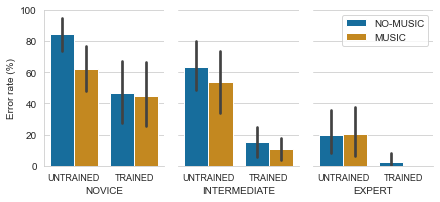

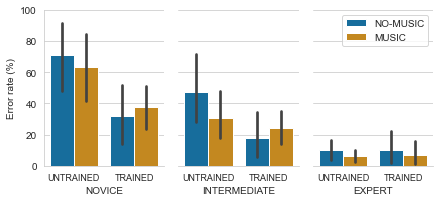

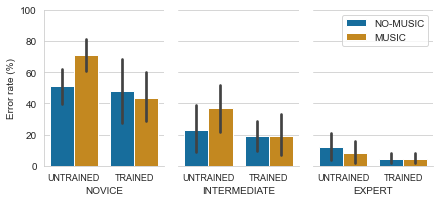

In [31]:
from utils.factorize import factorize_xticks, wrap_dv, wrap_factor

skills = ["Novice", "Intermediate", "Expert"]
techniques = ["Pitch", "Interval", "Melody"]

for technique in techniques:
    fig = plt.figure(constrained_layout=True)
    fig.set_figwidth(6)
    fig.set_figheight(2.7)
    gs = fig.add_gridspec(ncols=3, nrows=1, wspace=0.1)
    for col, classification in enumerate(skills):
        ax = fig.add_subplot(gs[0, col])
        curr_df = df[(df["Technique"] == technique) & (df["Skill"] == classification)]
        sns.barplot(
            data=curr_df,
            x="Training",
            y="Error rate",
            hue="Background",
            ci=95,
            n_boot=10000,
            ax=ax,
            palette=reg_palette,
        )

        ax.set_ylim(ymin=0, ymax=100)
        ax.set_xlabel(wrap_factor(skills[col]))

        factorize_xticks(ax)

        if col < 2:
            ax.get_legend().set_visible(False)
        if col != 0:
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        if col == 0:
            ax.set_ylabel("Error rate (%)")
        if col == 2:
            for text in ax.legend().get_texts():
                text.set_text(wrap_factor(text.get_text()))

        # Remove spines
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        if col != 0:
            ax.spines["left"].set_visible(False)

        # Reduce tick label size for x axis
        ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), fontsize=9)

    plt.show()